# Ferromagnetic Analysis

In [44]:
import pandas as pd
import numpy as np
from scipy.fftpack import fft, fftfreq, fftshift
from scipy import signal
from scipy.optimize import curve_fit
import matplotlib.pylab as plt
%matplotlib inline
plt.style.use('seaborn-paper')

## Import data simulated in oommf from csv

In [45]:
data1 = pd.read_csv("./data/pulse_xsize=1e-06.csv")
data1 = data1[[' Oxs_TimeDriver::Simulation time (s)', ' Oxs_TimeDriver::mx', ' Oxs_TimeDriver::my', ' Oxs_TimeDriver::mz']]
data1.columns = ['Time', 'mx', 'my', 'mz']

## Convert data to numeric type

Sometimes pandas does not read correctly the output file from oommf, so it does not convert correctly the values in the file to floats. This cell converts the values in the file to float in case pandas has not read them correctly

In [32]:
if(type(data1['Time'][0]) == str):
    data1['Time'] = data1['Time'].str.strip()
    data1['mz'] = data1['mz'].str.strip()
    data1['Time'] = pd.to_numeric(data1['Time'], errors='coerce')
    data1['mz'] = pd.to_numeric(data1['mz'], errors='coerce')
    data1 = data1.dropna()

## Find decay rate of magnetization oscillation

This cell find the peaks in the signal to later fit a exponential the shape described by these peaks

In [33]:
decayind = signal.find_peaks_cwt(data1['mz'], np.arange(1,80))
decay = []
x_decay = []
for index in decayind:
    x_decay.append(data1['Time'][index])
    decay.append(data1['mz'][index])

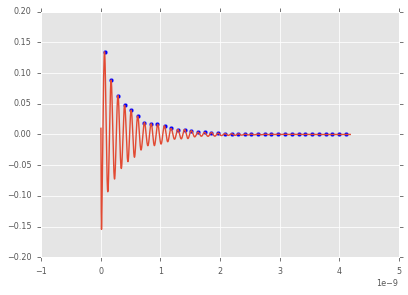

In [46]:
plt.plot(data1['Time'], data1['mz'])
plt.scatter(x_decay, decay)

Define exponential function to fit the peaks defined in the last cell. The last line fits the peaks of the magnetization to an exponential using the scipy.optimize function curve_fit 

In [35]:
def exponential(x, a, b):
    return a * np.exp(-b * x)
popt, pcov = curve_fit(exponential, x_decay, decay)

Show fitted decay 

The decay rate of mz is 2.67e+09


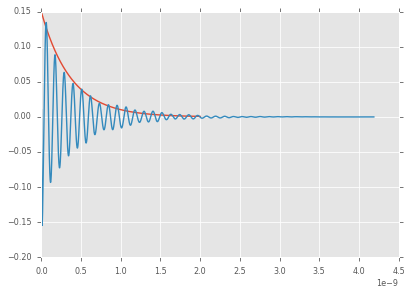

In [47]:
x = np.linspace(0, 2e-9, 1000)
y = exponential(np.array(x), *popt)
plt.plot(x, y)
plt.plot(data1['Time'], data1['mz'])
print('The decay rate of mz is {0:.3g}'.format(popt[1]))
decay_rates = []
decay_rates.append(popt[1])

## Frequency Analysis

* Define the time step used in the simulation
* Define the number of points in the simulation
* Perform the fourier transform to the magnetization values
* Define the frequency space using the scipy.fftpack function fftfreq

+ Use only positive frequency values for the analysis

In [37]:
dt = data1['Time'][1] - data1['Time'][0]
n = len(data1['mz']) 
mz_fft = fft(data1['mz'])
freq = fftfreq(n, dt)

mask = freq > 0
freq = freq[mask]
mz_fft = mz_fft[mask]

Plot the dominant frequencies present in the magnetization oscillation

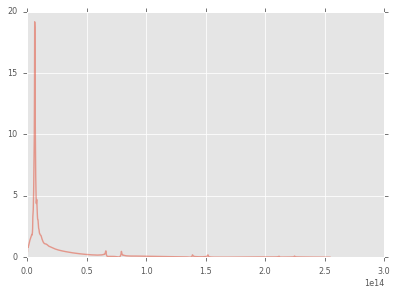

In [48]:
plt.plot(freq, abs(mz_fft), alpha = 0.5)

Define the dominant frequency

In [39]:
max_freq = freq[mz_fft.argmax()]
print('The dominating frequency is {0:.3g} Hz'.format(max_freq))

The dominating frequency is 9.37e+12 Hz


Find the peaks in the fourier transform to determine other present frequencies in the magnetization oscillation

In [40]:
peakind = signal.find_peaks_cwt(abs(mz_fft), np.arange(1,200))
peaks = []
x_peaks = []
for index in peakind:
    x_peaks.append(freq[index])
    peaks.append(abs(mz_fft[index]))  
    
    

Plot the fourier transform along with the detected peaks

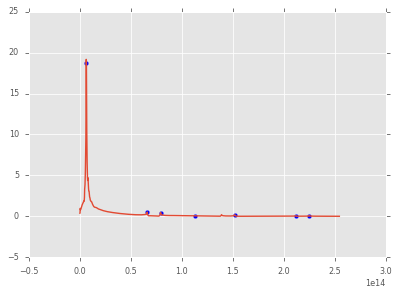

In [49]:
plt.scatter(x_peaks, peaks, c='b')
plt.plot(freq, abs(mz_fft))

In [29]:
np.array(x_peaks)/x_peaks[0]

array([  1.        ,  10.02631579,  12.05263158,  17.13157895,
        23.05263158,  32.10526316,  34.10526316])